## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import LeNet5, LeNet5Dropout, NaimishNet

net = LeNet5Dropout()
print(net)

LeNet5Dropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (dens4): Linear(in_features=15488, out_features=500, bias=True)
  (drop4): Dropout(p=0.5)
  (dens5): Linear(in_features=500, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, RandomVFlip, RandomContrastReduction, RandomRot, ToGrayScale, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((96, 96)), RandomVFlip(0.5), ToGrayScale(), RandomContrastReduction(0.5, 0.8), RandomRot(0.5, 5), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    return validation_batches(1)[0]
        
        
def validation_batches(num_batches=None):
    batches = []
    for i, sample in enumerate(test_loader):
        if i == num_batches:
            return batches
        
        images = sample['image']
        key_pts = sample['keypoints']

        images = images.type(torch.FloatTensor)
        output_pts = net(images)  
        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)        
        batches.append((images, output_pts, key_pts,))
        
    return batches            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 96, 96])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray', vmin=0, vmax=1.0)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

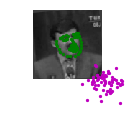

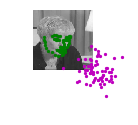

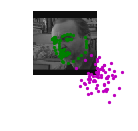

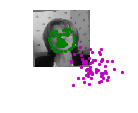

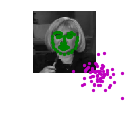

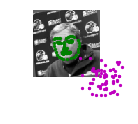

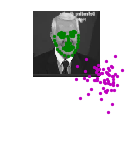

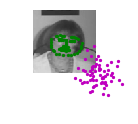

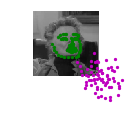

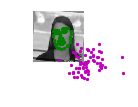

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def rmse_of_batch(predicted, actual):
    batch_size = len(actual)
    rmse = 0
    for i in range(0, batch_size):
        rmse += rmse_of_vectors(predicted[i].data.numpy(), actual[i].numpy())
    return rmse / batch_size

def rmse_of_vectors(predicted, actual):
    predicted = predicted.flatten()
    actual = actual.flatten()
    return np.sqrt(np.mean((predicted - actual)**2))

In [15]:
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    
    loss_over_time = []
    rmse_train_per_epoch = []
    rmse_valid_per_epoch = []
    
    lowest_error = 1.0
    patience = 60
    epochs_without_improvement = 0
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        last_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts_tensor = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts_tensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss / 10
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0
                
        v_error = validate()       
        
        rmse_train_per_epoch.append(rmse_of_batch(output_pts, key_pts)) 
        rmse_valid_per_epoch.append(v_error)     
        
        if v_error < lowest_error:
            lowest_error = v_error
            epochs_without_improvement = 0
            
            print("Saving currently best model with error: ", lowest_error)
            torch.save(net.state_dict(), 'saved_models/checkpoint.pt')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("Patience limit reached")
            break

    print('Finished Training')
    return loss_over_time, rmse_train_per_epoch, rmse_valid_per_epoch


def validate():
    num_test_batches = 0
    v_error = 0
    for _, test_outputs, gt_pts in validation_batches():
        v_error += rmse_of_batch(test_outputs, gt_pts)
        num_test_batches += 1

    return v_error / num_test_batches


In [27]:
# train your network
n_epochs = 300 # start small, and increase when you've decided on your model structure and hyperparams

training_loss, t_rmse, v_rmse = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0012809296662453563
Epoch: 1, Batch: 20, Avg. Loss: 0.0011628012405708432
Epoch: 1, Batch: 30, Avg. Loss: 0.0012545770849101245
Epoch: 1, Batch: 40, Avg. Loss: 0.0010341807443182915
Epoch: 1, Batch: 50, Avg. Loss: 0.0010832723404746504
Epoch: 1, Batch: 60, Avg. Loss: 0.0012253552151378245
Epoch: 1, Batch: 70, Avg. Loss: 0.0011458664725068957
Epoch: 1, Batch: 80, Avg. Loss: 0.001175763370702043
Epoch: 1, Batch: 90, Avg. Loss: 0.001205095328623429
Epoch: 1, Batch: 100, Avg. Loss: 0.0010736175056081266
Saving currently best model with error:  0.0354341244183
Epoch: 2, Batch: 10, Avg. Loss: 0.0012262364034540951
Epoch: 2, Batch: 20, Avg. Loss: 0.0011465505987871439
Epoch: 2, Batch: 30, Avg. Loss: 0.0012704583408776672
Epoch: 2, Batch: 40, Avg. Loss: 0.0011774453101679682
Epoch: 2, Batch: 50, Avg. Loss: 0.0010897160216700285
Epoch: 2, Batch: 60, Avg. Loss: 0.0012110658455640078
Epoch: 2, Batch: 70, Avg. Loss: 0.001078029937343672
Epoch: 2, Batch: 80, Avg. L

Epoch: 15, Batch: 100, Avg. Loss: 0.0011202294903341682
Epoch: 16, Batch: 10, Avg. Loss: 0.001309823855990544
Epoch: 16, Batch: 20, Avg. Loss: 0.0011388650629669428
Epoch: 16, Batch: 30, Avg. Loss: 0.0010499348572921008
Epoch: 16, Batch: 40, Avg. Loss: 0.0010456773859914392
Epoch: 16, Batch: 50, Avg. Loss: 0.0010851927916519343
Epoch: 16, Batch: 60, Avg. Loss: 0.001092756539583206
Epoch: 16, Batch: 70, Avg. Loss: 0.0011508438212331385
Epoch: 16, Batch: 80, Avg. Loss: 0.0011896123411133885
Epoch: 16, Batch: 90, Avg. Loss: 0.001178042037645355
Epoch: 16, Batch: 100, Avg. Loss: 0.0010742160666268319
Epoch: 17, Batch: 10, Avg. Loss: 0.0012947442708536982
Epoch: 17, Batch: 20, Avg. Loss: 0.0011759209912270308
Epoch: 17, Batch: 30, Avg. Loss: 0.0011137546214740723
Epoch: 17, Batch: 40, Avg. Loss: 0.0011725947610102595
Epoch: 17, Batch: 50, Avg. Loss: 0.0010588298668153585
Epoch: 17, Batch: 60, Avg. Loss: 0.0011272622679825873
Epoch: 17, Batch: 70, Avg. Loss: 0.001096863200655207
Epoch: 17, B

Epoch: 30, Batch: 100, Avg. Loss: 0.0011965617770329118
Epoch: 31, Batch: 10, Avg. Loss: 0.0010537872149143368
Epoch: 31, Batch: 20, Avg. Loss: 0.0011153869912959636
Epoch: 31, Batch: 30, Avg. Loss: 0.0011392624233849346
Epoch: 31, Batch: 40, Avg. Loss: 0.0011721826042048634
Epoch: 31, Batch: 50, Avg. Loss: 0.0011680023628287018
Epoch: 31, Batch: 60, Avg. Loss: 0.001130901405122131
Epoch: 31, Batch: 70, Avg. Loss: 0.0010227574384771287
Epoch: 31, Batch: 80, Avg. Loss: 0.0012156380631495266
Epoch: 31, Batch: 90, Avg. Loss: 0.0011236133286729455
Epoch: 31, Batch: 100, Avg. Loss: 0.001107545499689877
Epoch: 32, Batch: 10, Avg. Loss: 0.0011540845967829227
Epoch: 32, Batch: 20, Avg. Loss: 0.001281140127684921
Epoch: 32, Batch: 30, Avg. Loss: 0.0011666451813653112
Epoch: 32, Batch: 40, Avg. Loss: 0.0011536161124240606
Epoch: 32, Batch: 50, Avg. Loss: 0.0011799186526332051
Epoch: 32, Batch: 60, Avg. Loss: 0.001146590826101601
Epoch: 32, Batch: 70, Avg. Loss: 0.0010767943575046956
Epoch: 32, B

Epoch: 45, Batch: 100, Avg. Loss: 0.001105506275780499
Epoch: 46, Batch: 10, Avg. Loss: 0.0010460449557285756
Epoch: 46, Batch: 20, Avg. Loss: 0.0010533580847550184
Epoch: 46, Batch: 30, Avg. Loss: 0.0012217683834023774
Epoch: 46, Batch: 40, Avg. Loss: 0.0011021030019037425
Epoch: 46, Batch: 50, Avg. Loss: 0.0009645741258282215
Epoch: 46, Batch: 60, Avg. Loss: 0.0011390807630959898
Epoch: 46, Batch: 70, Avg. Loss: 0.0011187616910319775
Epoch: 46, Batch: 80, Avg. Loss: 0.0010972424410283566
Epoch: 46, Batch: 90, Avg. Loss: 0.001112782908603549
Epoch: 46, Batch: 100, Avg. Loss: 0.0010467181738931686
Epoch: 47, Batch: 10, Avg. Loss: 0.0011914853763300925
Epoch: 47, Batch: 20, Avg. Loss: 0.0010872825863771141
Epoch: 47, Batch: 30, Avg. Loss: 0.0011936957482248545
Epoch: 47, Batch: 40, Avg. Loss: 0.0012902185902930797
Epoch: 47, Batch: 50, Avg. Loss: 0.0011804392910562457
Epoch: 47, Batch: 60, Avg. Loss: 0.001056348584825173
Epoch: 47, Batch: 70, Avg. Loss: 0.0011506874696351587
Epoch: 47, 

Epoch: 60, Batch: 90, Avg. Loss: 0.001142376393545419
Epoch: 60, Batch: 100, Avg. Loss: 0.0009983390686102212
Epoch: 61, Batch: 10, Avg. Loss: 0.0011071594490204006
Epoch: 61, Batch: 20, Avg. Loss: 0.0011718824913259595
Epoch: 61, Batch: 30, Avg. Loss: 0.0010483702644705772
Epoch: 61, Batch: 40, Avg. Loss: 0.001097901217872277
Epoch: 61, Batch: 50, Avg. Loss: 0.001161323010455817
Epoch: 61, Batch: 60, Avg. Loss: 0.0011301705555524677
Epoch: 61, Batch: 70, Avg. Loss: 0.000996480934554711
Epoch: 61, Batch: 80, Avg. Loss: 0.0010777149291243404
Epoch: 61, Batch: 90, Avg. Loss: 0.0011077555711381138
Epoch: 61, Batch: 100, Avg. Loss: 0.0010762906807940454
Epoch: 62, Batch: 10, Avg. Loss: 0.00106013115728274
Epoch: 62, Batch: 20, Avg. Loss: 0.001168796163983643
Epoch: 62, Batch: 30, Avg. Loss: 0.0011820674408227205
Epoch: 62, Batch: 40, Avg. Loss: 0.0011540407838765531
Epoch: 62, Batch: 50, Avg. Loss: 0.0010835037275683135
Epoch: 62, Batch: 60, Avg. Loss: 0.0010186598403379322
Epoch: 62, Batc

Epoch: 75, Batch: 80, Avg. Loss: 0.0010693737072870134
Epoch: 75, Batch: 90, Avg. Loss: 0.001069972146069631
Epoch: 75, Batch: 100, Avg. Loss: 0.0011948919447604567
Epoch: 76, Batch: 10, Avg. Loss: 0.0010523407603614033
Epoch: 76, Batch: 20, Avg. Loss: 0.0010511565720662474
Epoch: 76, Batch: 30, Avg. Loss: 0.0010582548333331943
Epoch: 76, Batch: 40, Avg. Loss: 0.0011186916672158986
Epoch: 76, Batch: 50, Avg. Loss: 0.0010974260047078132
Epoch: 76, Batch: 60, Avg. Loss: 0.0010889396362472326
Epoch: 76, Batch: 70, Avg. Loss: 0.0011013471463229506
Epoch: 76, Batch: 80, Avg. Loss: 0.001115842821309343
Epoch: 76, Batch: 90, Avg. Loss: 0.0011890618479810655
Epoch: 76, Batch: 100, Avg. Loss: 0.0012819834286347032
Epoch: 77, Batch: 10, Avg. Loss: 0.0010198392497841268
Epoch: 77, Batch: 20, Avg. Loss: 0.0011182037298567594
Epoch: 77, Batch: 30, Avg. Loss: 0.0011338369804434478
Epoch: 77, Batch: 40, Avg. Loss: 0.0010750941059086473
Epoch: 77, Batch: 50, Avg. Loss: 0.0010939844767563045
Epoch: 77,

Epoch: 90, Batch: 60, Avg. Loss: 0.0010073075420223177
Epoch: 90, Batch: 70, Avg. Loss: 0.001050310203572735
Epoch: 90, Batch: 80, Avg. Loss: 0.0010093017073813826
Epoch: 90, Batch: 90, Avg. Loss: 0.0011216474696993828
Epoch: 90, Batch: 100, Avg. Loss: 0.0010294853069353848
Epoch: 91, Batch: 10, Avg. Loss: 0.0010254190943669527
Epoch: 91, Batch: 20, Avg. Loss: 0.0010843177500646562
Epoch: 91, Batch: 30, Avg. Loss: 0.0011866786633618176
Epoch: 91, Batch: 40, Avg. Loss: 0.0011210894910618663
Epoch: 91, Batch: 50, Avg. Loss: 0.0010367028997279703
Epoch: 91, Batch: 60, Avg. Loss: 0.0010128819500096141
Epoch: 91, Batch: 70, Avg. Loss: 0.001031194144161418
Epoch: 91, Batch: 80, Avg. Loss: 0.0010432362963911147
Epoch: 91, Batch: 90, Avg. Loss: 0.0010149855457711964
Epoch: 91, Batch: 100, Avg. Loss: 0.0011828356247860939
Epoch: 92, Batch: 10, Avg. Loss: 0.0012020991242025047
Epoch: 92, Batch: 20, Avg. Loss: 0.0010882550268433988
Epoch: 92, Batch: 30, Avg. Loss: 0.001052595302462578
Epoch: 92, 

Epoch: 105, Batch: 50, Avg. Loss: 0.0010566153330728411
Epoch: 105, Batch: 60, Avg. Loss: 0.001092653110390529
Epoch: 105, Batch: 70, Avg. Loss: 0.0010682858875952661
Epoch: 105, Batch: 80, Avg. Loss: 0.001074368617264554
Epoch: 105, Batch: 90, Avg. Loss: 0.0011158692010212689
Epoch: 105, Batch: 100, Avg. Loss: 0.0010707351029850543
Saving currently best model with error:  0.0335757856213
Epoch: 106, Batch: 10, Avg. Loss: 0.0009443266608286649
Epoch: 106, Batch: 20, Avg. Loss: 0.0011620148259680718
Epoch: 106, Batch: 30, Avg. Loss: 0.0009459433320444077
Epoch: 106, Batch: 40, Avg. Loss: 0.0010208729829173536
Epoch: 106, Batch: 50, Avg. Loss: 0.0010242089454550296
Epoch: 106, Batch: 60, Avg. Loss: 0.0012236917042173444
Epoch: 106, Batch: 70, Avg. Loss: 0.0010419072408694775
Epoch: 106, Batch: 80, Avg. Loss: 0.0010129638249054551
Epoch: 106, Batch: 90, Avg. Loss: 0.001043821341590956
Epoch: 106, Batch: 100, Avg. Loss: 0.001040941331302747
Epoch: 107, Batch: 10, Avg. Loss: 0.0010645210859

Epoch: 120, Batch: 10, Avg. Loss: 0.00107232570881024
Epoch: 120, Batch: 20, Avg. Loss: 0.0011058691539801656
Epoch: 120, Batch: 30, Avg. Loss: 0.0010266030963975935
Epoch: 120, Batch: 40, Avg. Loss: 0.0010436563286930322
Epoch: 120, Batch: 50, Avg. Loss: 0.001060627488186583
Epoch: 120, Batch: 60, Avg. Loss: 0.0010978932783473282
Epoch: 120, Batch: 70, Avg. Loss: 0.0009907727537211031
Epoch: 120, Batch: 80, Avg. Loss: 0.0010948021721560509
Epoch: 120, Batch: 90, Avg. Loss: 0.001052013208391145
Epoch: 120, Batch: 100, Avg. Loss: 0.0010897726053372026
Epoch: 121, Batch: 10, Avg. Loss: 0.0011694387532770634
Epoch: 121, Batch: 20, Avg. Loss: 0.001037112734047696
Epoch: 121, Batch: 30, Avg. Loss: 0.0011454531166236847
Epoch: 121, Batch: 40, Avg. Loss: 0.0010694879398215561
Epoch: 121, Batch: 50, Avg. Loss: 0.0010679033643100412
Epoch: 121, Batch: 60, Avg. Loss: 0.0009982462623156607
Epoch: 121, Batch: 70, Avg. Loss: 0.0011024425097275526
Epoch: 121, Batch: 80, Avg. Loss: 0.0009903498052153

Epoch: 134, Batch: 60, Avg. Loss: 0.0011091152613516898
Epoch: 134, Batch: 70, Avg. Loss: 0.0010289616242516787
Epoch: 134, Batch: 80, Avg. Loss: 0.001001661701593548
Epoch: 134, Batch: 90, Avg. Loss: 0.0010158287303056567
Epoch: 134, Batch: 100, Avg. Loss: 0.0010334041551686823
Epoch: 135, Batch: 10, Avg. Loss: 0.00113006645697169
Epoch: 135, Batch: 20, Avg. Loss: 0.0010470331006217747
Epoch: 135, Batch: 30, Avg. Loss: 0.0009687233134172857
Epoch: 135, Batch: 40, Avg. Loss: 0.0009766614122781903
Epoch: 135, Batch: 50, Avg. Loss: 0.0010045466595329344
Epoch: 135, Batch: 60, Avg. Loss: 0.001012401416664943
Epoch: 135, Batch: 70, Avg. Loss: 0.0009960825147572905
Epoch: 135, Batch: 80, Avg. Loss: 0.001049191551283002
Epoch: 135, Batch: 90, Avg. Loss: 0.001092944759875536
Epoch: 135, Batch: 100, Avg. Loss: 0.0010872837388888
Epoch: 136, Batch: 10, Avg. Loss: 0.00122963308240287
Epoch: 136, Batch: 20, Avg. Loss: 0.0011574382544495166
Epoch: 136, Batch: 30, Avg. Loss: 0.0011283541796728968
E

Epoch: 149, Batch: 30, Avg. Loss: 0.0010394185315817594
Epoch: 149, Batch: 40, Avg. Loss: 0.0010002430935855955
Epoch: 149, Batch: 50, Avg. Loss: 0.0009352145891170949
Epoch: 149, Batch: 60, Avg. Loss: 0.001101928041316569
Epoch: 149, Batch: 70, Avg. Loss: 0.0010579736495856195
Epoch: 149, Batch: 80, Avg. Loss: 0.001018776063574478
Epoch: 149, Batch: 90, Avg. Loss: 0.0010548340913373977
Epoch: 149, Batch: 100, Avg. Loss: 0.0010678091668523848
Epoch: 150, Batch: 10, Avg. Loss: 0.0010060715721920133
Epoch: 150, Batch: 20, Avg. Loss: 0.0011335372342728077
Epoch: 150, Batch: 30, Avg. Loss: 0.0009656432142946869
Epoch: 150, Batch: 40, Avg. Loss: 0.0011550584982614963
Epoch: 150, Batch: 50, Avg. Loss: 0.0009673604450654239
Epoch: 150, Batch: 60, Avg. Loss: 0.000988520635291934
Epoch: 150, Batch: 70, Avg. Loss: 0.0010067028517369181
Epoch: 150, Batch: 80, Avg. Loss: 0.0010055979422759266
Epoch: 150, Batch: 90, Avg. Loss: 0.0009867450804449617
Epoch: 150, Batch: 100, Avg. Loss: 0.0010895727435

Epoch: 163, Batch: 100, Avg. Loss: 0.0009930970089044421
Epoch: 164, Batch: 10, Avg. Loss: 0.000963982695247978
Epoch: 164, Batch: 20, Avg. Loss: 0.0011234476347453891
Epoch: 164, Batch: 30, Avg. Loss: 0.0009485389571636915
Epoch: 164, Batch: 40, Avg. Loss: 0.0010217457311227918
Epoch: 164, Batch: 50, Avg. Loss: 0.0009577481949236244
Epoch: 164, Batch: 60, Avg. Loss: 0.0009264655527658761
Epoch: 164, Batch: 70, Avg. Loss: 0.0010340395732782782
Epoch: 164, Batch: 80, Avg. Loss: 0.0009816734585911036
Epoch: 164, Batch: 90, Avg. Loss: 0.001006703992607072
Epoch: 164, Batch: 100, Avg. Loss: 0.0010420323233120143
Epoch: 165, Batch: 10, Avg. Loss: 0.0009448935918044299
Epoch: 165, Batch: 20, Avg. Loss: 0.0010569174017291516
Epoch: 165, Batch: 30, Avg. Loss: 0.0010803088021930306
Epoch: 165, Batch: 40, Avg. Loss: 0.0010272364714182913
Epoch: 165, Batch: 50, Avg. Loss: 0.001075716648483649
Epoch: 165, Batch: 60, Avg. Loss: 0.0010267697740346192
Epoch: 165, Batch: 70, Avg. Loss: 0.0009836039971

Process Process-6206:
Process Process-6207:
Process Process-6205:
Process Process-6208:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ramlb/work/repos/P1_Facial_Keypoints/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_

KeyboardInterrupt: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

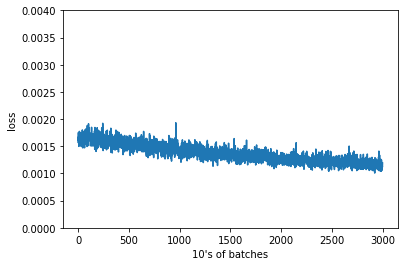

Minimum loss 0.001006991951726377


In [28]:
plt.plot(training_loss)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 0.004) # consistent scale
plt.show()
print("Minimum loss", min(training_loss))

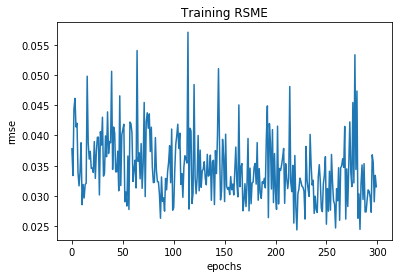

Minimum train RSME 0.0243750180585


In [29]:
plt.plot(t_rmse)
plt.title('Training RSME')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()
print("Minimum train RSME", min(t_rmse))

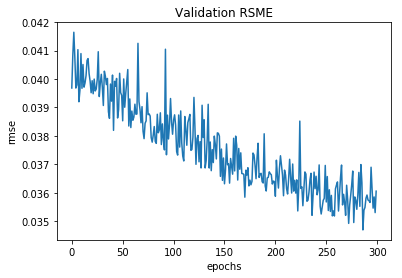

Minimum valid RSME 0.0346941595676


In [30]:
plt.plot(v_rmse)
plt.title('Validation RSME')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()
print("Minimum valid RSME", min(v_rmse))

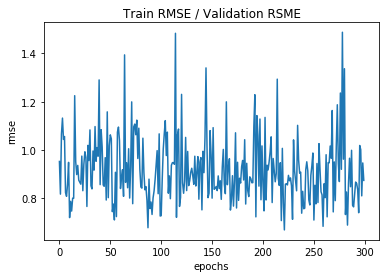

Last T/V quotient 0.873935261761


In [31]:
quotient = np.array(t_rmse) / np.array(v_rmse)
plt.plot(quotient)
plt.title('Train RMSE / Validation RSME')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()
print("Last T/V quotient", quotient[-1])

In [34]:
# get a sample of test data again
net.load_state_dict(torch.load('saved_models/checkpoint.pt'))
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 96, 96])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


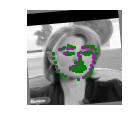

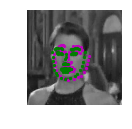

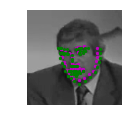

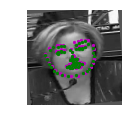

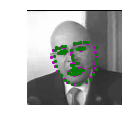

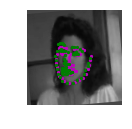

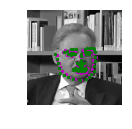

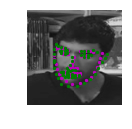

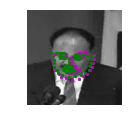

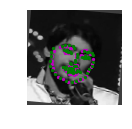

In [35]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [36]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_96x96_best_slowtr.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!